## Execute

Once you have defined your FFmpeg processing pipeline in Typed-FFmpeg, executing the command or inspecting the underlying FFmpeg command is straightforward. This section covers how to run your FFmpeg tasks programmatically and how to retrieve the command line equivalent for debugging or educational purposes.


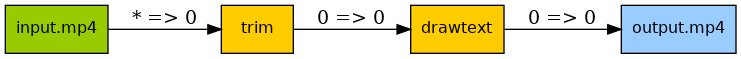

In [14]:
import ffmpeg

# Define the FFmpeg command with filters and output
input_stream = ffmpeg.input("input.mp4")
f = (
    input_stream.trim(start=10, end=20)
    .drawtext(text="Hello World", fontsize=12, x=10, y=10)
    .output(filename="output.mp4")
)
f

```python
# Execute the FFmpeg command
f.run()
```


### Retrieving the Command Line

For debugging or verification purposes, you might want to inspect the exact command line that Typed-FFmpeg will execute. This can be done using the .compile() or .command_line() methods. These methods are especially useful for understanding how Typed-FFmpeg translates your Python code into FFmpeg command-line arguments.


In [15]:
# Compile the FFmpeg command into a list format
command_list = f.compile()
command_list

['ffmpeg',
 '-i',
 'input.mp4',
 '-filter_complex',
 '[0]trim=start=10:end=20[s0];[s0]drawtext=text=Hello World:fontsize=12:x=10:y=10[s1]',
 '-map',
 '[s1]',
 'output.mp4']

In [16]:
# Alternatively, get the command line as a single string
command_string = f.compile_line()
command_string

"ffmpeg -i input.mp4 -filter_complex '[0]trim=start=10:end=20[s0];[s0]drawtext=text=Hello World:fontsize=12:x=10:y=10[s1]' -map '[s1]' output.mp4"

These methods are primarily intended for debugging and ensuring that the Typed-FFmpeg commands align with your expectations.


### Visualizing the Command

Typed-FFmpeg also offers a method to visualize your filter graph, which can help in understanding the flow and structure of your FFmpeg command. This is particularly helpful when dealing with complex filter chains or multi-stream workflows.


In [17]:
# Visualize the FFmpeg filter graph
f.view()

'Digraph.gv.png'

Utilizing the .view() method renders a graphical representation of your command's filter graph, providing a clear and intuitive overview of how your streams and filters are interconnected.

By following these steps, you can effectively execute, debug, and visualize your video and audio processing tasks within the Typed-FFmpeg framework.


### Validate & Auto Fix with Typed-FFmpeg

Typed-FFmpeg introduces an advanced feature for validating and automatically correcting your FFmpeg commands. This functionality is invaluable for ensuring that your commands are not only syntactically correct but also adhere to FFmpeg's operational requirements, which can sometimes be non-intuitive and lead to user confusion.

#### Resolving Missing Split Filters

A common issue in FFmpeg commands is the improper reuse of filtered streams without a split. FFmpeg requires distinct stream references when a stream is used in multiple contexts. Typed-FFmpeg can automatically insert necessary split filters to rectify this.

**Example of a Missing Split Filter Issue:**

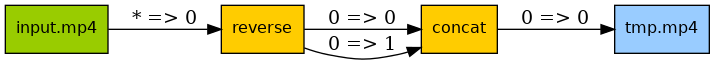

In [24]:
from ffmpeg import input
from ffmpeg.filters import concat

# Define a problematic FFmpeg graph without the required split
input_stream = input("input.mp4")
stream = input_stream.reverse()
graph = concat(stream, stream).video(0).output(filename="tmp.mp4")
graph

In [25]:
# Attempt to compile the command without auto-fixing
graph.compile_line(auto_fix=False)
# Incorrect command: ffmpeg -i input.mp4 -filter_complex '[0:v]reverse[r];[r][r]concat[c]' -map '[c]' tmp.mp4

"ffmpeg -i input.mp4 -filter_complex '[0]reverse[s0];[s0][s0]concat=n=2[s1]' -map '[s1]' tmp.mp4"

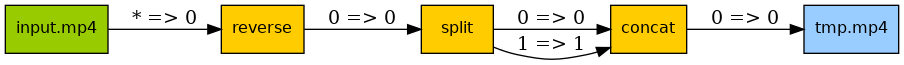

In [30]:
# typed-ffmpeg's built-in validation will catch the issue and suggest a fix

from ffmpeg.dag.validate import validate

validate(graph)

In [31]:
# Automatically fix and compile the command
graph.compile_line()
# Corrected command: ffmpeg -i input.mp4 -filter_complex '[0:v]reverse[r];[r]split=2[s1][s2];[s1][s2]concat[c]' -map '[c]' tmp.mp4

"ffmpeg -i input.mp4 -filter_complex '[0]reverse[s0];[s0]split=outputs=2[s1#0][s1#1];[s1#0][s1#1]concat=n=2[s2]' -map '[s2]' tmp.mp4"


In this case, Typed-FFmpeg intelligently adds a split filter to meet FFmpeg's requirements for stream usage.

#### Eliminating Redundant Split Filters

Conversely, unnecessary split filters can also introduce problems, such as unintended stream selections or inefficient processing. Typed-FFmpeg can identify and remove these redundant filters, streamlining your command.

**Example of Redundant Split Filter Issue:**

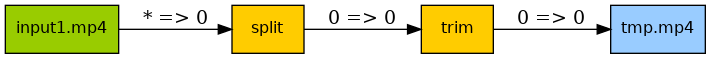

In [35]:
from ffmpeg import input

# Set up an FFmpeg graph with a redundant split
input1 = input("input1.mp4")
f = input1.split(outputs=2).video(0).trim(end=5).output(filename="tmp.mp4")
f

In [39]:
# Compile the command with the redundant split, without auto-fixing
f.compile_line(auto_fix=False)
# Inefficient command: ffmpeg -i input1.mp4 -filter_complex '[0:v]split=2[s0][s1];[s0]trim=end=5[t]' -map '[t]' tmp.mp4

"ffmpeg -i input1.mp4 -filter_complex '[0]split=outputs=2[s0#0];[s0#0]trim=end=5[s1]' -map '[s1]' tmp.mp4"

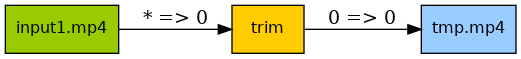

In [38]:
# typed-ffmpeg's built-in validation will catch the issue and suggest a fix

from ffmpeg.dag.validate import validate

validate(f)

In [40]:
# Auto-remove the redundant split and compile
f.compile_line()
# Optimized command: ffmpeg -i input1.mp4 -filter_complex '[0:v]trim=end=5[t]' -map '[t]' tmp.mp4

"ffmpeg -i input1.mp4 -filter_complex '[0]trim=end=5[s0]' -map '[s0]' tmp.mp4"


In this example, Typed-FFmpeg eliminates the unnecessary split, thereby simplifying the command and potentially improving processing efficiency.

#### Conclusion

Typed-FFmpeg's validation and auto-fixing capabilities greatly enhance the user experience by automating the resolution of common issues and optimizing command structure. This ensures that users can focus more on their creative and technical goals rather than on navigating the intricacies of FFmpeg's syntax and stream management rules.
